# H2 in sto-3g

In [138]:
import numpy as np
import matplotlib.pyplot as plt


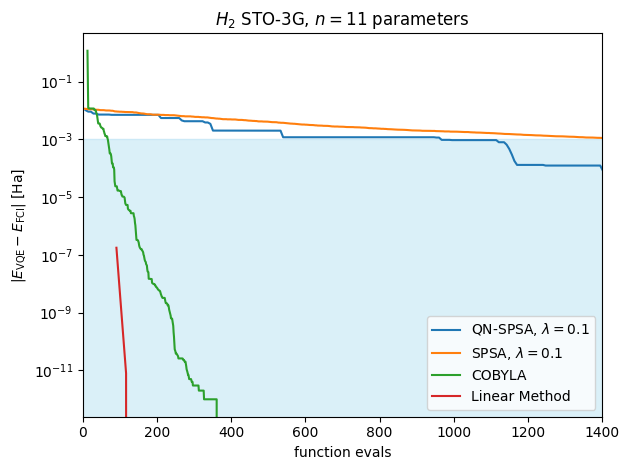

In [139]:
E_FCI = -1.137117067346
methods = [
    {
        "label": r"QN-SPSA, $\lambda = 0.1$",
        "path": "../data/vqe/h2_sto3g/QNSPSA_reg=0.1.csv",
        "x_col": 1,   # nfev column in SPSA file
        "E_col": 2,   # energy column in SPSA file
        "skiprows": 1,
        "use": slice(None)
    },
    {
        "label": r"SPSA, $\lambda = 0.1$",
        "path": "../data/vqe/h2_sto3g/SPSA_reg=0.1.csv",
        "x_col": 1,   # nfev column in SPSA file
        "E_col": 2,   # energy column in SPSA file
        "skiprows": 1,
        "use": slice(None)
    },
    {
    "label": r"COBYLA",
    "path": "../data/vqe/h2_sto3g/cobyla.csv",
    "x_col": 1,   # nfev column in SPSA file
    "E_col": 2,   # energy column in SPSA file
    "skiprows": 1,
    "use": slice(None)
    },
    {
    "label": r"Linear Method",
    "path": "../data/vqe/h2_sto3g/LM_h2.csv",
    "x_col": 2,   # nfev column in SPSA file
    "E_col": 3,   # energy column in SPSA file
    "skiprows": 1,
    "use": slice(None)
    }
]

series1 = []  
for m in methods:
    data = np.loadtxt(m["path"], delimiter=",", skiprows=m.get("skiprows", 0))
    nfev = data[:, m["x_col"]][m["use"]]
    E = data[:, m["E_col"]][m["use"]]
    E_best = np.minimum.accumulate(E)
    dE = np.abs(E_best - E_FCI)

    series1.append((m["label"], nfev, dE, E_best))

plt.figure()
for label, nfev, dE, _ in series1:
    plt.semilogy(nfev, dE, label=label)
plt.title(r"$H_2$ STO-3G, $n=11$ parameters ")
x = np.arange(0,1500)
plt.xlim(0,1400)
plt.fill_between(x, 0, 1e-3, color='skyblue', alpha=0.3)
plt.xlabel("function evals")
plt.ylabel(r"$|E_{\mathrm{VQE}} - E_{\mathrm{FCI}}|$ [Ha]")
plt.tight_layout()
plt.legend()

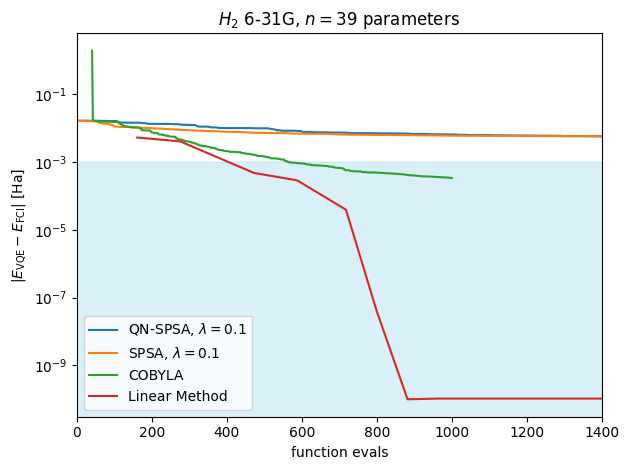

In [140]:
E_FCI = -1.151688547413

methods = [
    {
        "label": r"QN-SPSA, $\lambda = 0.1$",
        "path": "../data/vqe/h2_631g/qnspsa.csv",
        "x_col": 1,  
        "E_col": 2,   
        "skiprows": 1,
        "use": slice(None)
    },
    {
        "label": r"SPSA, $\lambda = 0.1$",
        "path": "../data/vqe/h2_631g/spsa.csv",
        "x_col": 1,  
        "E_col": 2,   
        "skiprows": 1,
        "use": slice(None)
    },
    {
        "label": r"COBYLA",
        "path": "../data/vqe/h2_631g/cobyla.csv",
        "x_col": 1,   
        "E_col": 2,   
        "skiprows": 1,
        "use": slice(None)
    },
    {
        "label": r"Linear Method",
        "path": "../data/vqe/h2_631g/lm.csv",
        "x_col": 2,  
        "E_col": 3,   
        "skiprows": 1,
        "use": slice(None)
    },
]

series2 = []  
for m in methods:
    data = np.loadtxt(m["path"], delimiter=",", skiprows=m.get("skiprows", 0))
    nfev = data[:, m["x_col"]][m["use"]]
    E = data[:, m["E_col"]][m["use"]]
    E_best = np.minimum.accumulate(E)
    dE = np.abs(E_best - E_FCI)

    series2.append((m["label"], nfev, dE, E_best))

plt.figure()
for label, nfev, dE, _ in series2:
    plt.semilogy(nfev, dE, label=label)
plt.title(r"$H_2$ 6-31G, $n=39$ parameters ")
x = np.arange(0,1500)
plt.xlim(0,1400)
plt.fill_between(x, 0, 1e-3, color='skyblue', alpha=0.3)
plt.xlabel("function evals")
plt.ylabel(r"$|E_{\mathrm{VQE}} - E_{\mathrm{FCI}}|$ [Ha]")
plt.tight_layout()
plt.legend()

# N2 in sto-6g

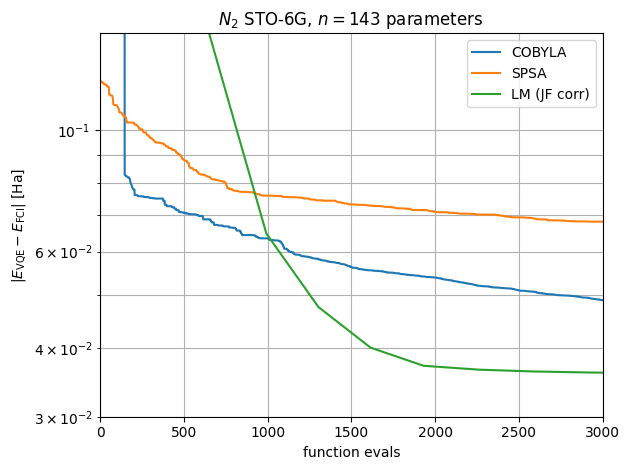

In [141]:
E_FCI = -108.701561742329  # Ha

methods = [
    {
        "label": r"COBYLA",
        "path": "../data/vqe/n2_sto6g/cobyla.csv",
        "x_col": 1,   
        "E_col": 2,  
        "skiprows": 1,
        "use": slice(None)
    },
    {
        "label": r"SPSA",
        "path": "../data/vqe/n2_sto6g/spsa_reg=0.5.csv",
        "x_col": 1,  
        "E_col": 2,  
        "skiprows": 1,
        "use": slice(None)
    },
    {
        "label": "LM (JF corr)",
        "path": "../data/vqe/n2_sto6g/LM_n2.csv",
        "x_col": 1,   
        "E_col": 2,   
        "skiprows": 1,
        "use": slice(None)
    }
]

series3 = []  
for m in methods:
    data = np.loadtxt(m["path"], delimiter=",", skiprows=m.get("skiprows", 0))
    nfev = data[:, m["x_col"]][m["use"]]
    E = data[:, m["E_col"]][m["use"]]
    E_best = np.minimum.accumulate(E)
    dE = np.abs(E_best - E_FCI)

    series3.append((m["label"], nfev, dE, E_best))


plt.figure()
for label, nfev, dE, _ in series3:
    plt.semilogy(nfev, dE, label=label)
plt.ylim([3e-2,1.5e-1])
plt.xlim((0,3000))
plt.title(r"$N_2$ STO-6G, $n=143$ parameters ")
plt.xlabel("function evals")
plt.ylabel(r"$|E_{\mathrm{VQE}} - E_{\mathrm{FCI}}|$ [Ha]")
plt.grid(True, which="both")
plt.fill_between(np.arange(0,3000), 0, 1e-3, color='skyblue', alpha=0.3)
plt.tight_layout()
plt.legend()
plt.savefig("n2_sto6g_vqe.png", dpi=400)

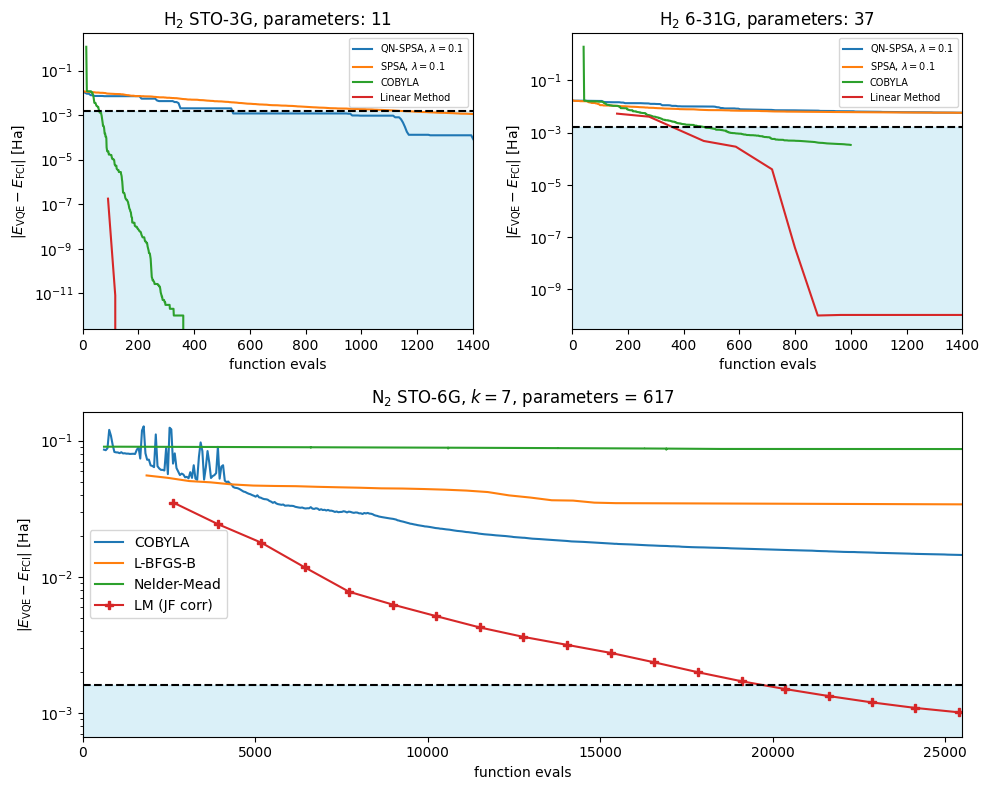

In [142]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.1])

ax11 = fig.add_subplot(gs[0, 0])   
ax12 = fig.add_subplot(gs[0, 1])     
ax21 = fig.add_subplot(gs[1, :])     

E_FCI_h2_sto3g = -1.137162777375
for label, nfev, dE, _ in series1:
    ax11.semilogy(nfev, dE, label=label)

ax11.set_title(r"H$_2$ STO-3G, parameters: 11")
ax11.set_xlabel("function evals")
ax11.set_ylabel(r"$|E_{\mathrm{VQE}} - E_{\mathrm{FCI}}|$ [Ha]")
ax11.legend(fontsize=7)
ax11.axhline(1.594e-3, linestyle='--', c='k')

x_fill = np.linspace(0, 1400, 200)
ax11.fill_between(x_fill, 0, 1.594e-3, color='skyblue', alpha=0.3)
ax11.set_xlim([0, 1400])


E_FCI_h2_631g = -1.151721517222
for label, nfev, dE, _ in series2:
    ax12.semilogy(nfev, dE, label=label)

ax12.set_title(r"H$_2$ 6-31G, parameters: 37")
ax12.set_xlabel("function evals")
ax12.set_ylabel(r"$|E_{\mathrm{VQE}} - E_{\mathrm{FCI}}|$ [Ha]")
ax12.legend(fontsize=7)
ax12.axhline(1.594e-3, linestyle='--', c='k')

ax12.fill_between(x_fill, 0, 1.594e-3, color='skyblue', alpha=0.3)
ax12.set_xlim([0, 1400])


E_FCI_n2 = -108.701561742329 
lmk5 = np.loadtxt("../data/vqe/n2_sto6g/LM_k=7.csv", skiprows=1, delimiter=',')
nfev_lm, E_lm = lmk5[:, 0], lmk5[:, 1]

cobylak5 = np.loadtxt("../data/vqe/n2_sto6g/cobyla_k=7.csv", skiprows=1, delimiter=',')
nfev_cobyla = cobylak5[:, 1][0:-1:25]
E_cobyla = cobylak5[:, 2][0:-1:25]

lbfgsb = np.loadtxt("../data/vqe/n2_sto6g/l-bfgs-b.csv", skiprows=1, delimiter=',')
nfev_lbfgsb, E_lbfgsb = lbfgsb[:, 1], lbfgsb[:, 2]

nm = np.loadtxt("../data/vqe/n2_sto6g/nm.csv", skiprows=1, delimiter=',')
nfev_nm, E_nm = nm[:, 1], nm[:, 2]

ax21.semilogy(nfev_cobyla, np.abs(E_FCI_n2 - E_cobyla), label="COBYLA")
ax21.semilogy(nfev_lbfgsb, np.abs(E_FCI_n2 - E_lbfgsb), label="L-BFGS-B")
ax21.semilogy(nfev_nm, np.abs(E_FCI_n2 - E_nm), label="Nelder-Mead")
ax21.semilogy(nfev_lm, np.abs(E_FCI_n2 - E_lm), 'P-', label="LM (JF corr)")

ax21.set_title(r"N$_2$ STO-6G, $k=7$, parameters = 617")
ax21.set_xlabel("function evals")
ax21.set_ylabel(r"$|E_{\mathrm{VQE}} - E_{\mathrm{FCI}}|$ [Ha]")
ax21.legend()

ax21.axhline(1.594e-3, linestyle='--', c='k')
x_fill_bottom = np.linspace(0, 25500, 200)
ax21.fill_between(x_fill_bottom, 0, 1.594e-3, color='skyblue', alpha=0.3)
ax21.set_xlim([0, 25500])

plt.tight_layout()
plt.savefig("vqe_overview.png", dpi=400)
plt.show()
